### オートエンコーダー
入力を復元することが出来る潜在空間を見つける。<br>
オートエンコーダーは二つのマスからできている。<br>
input → encoder(元の画像を低次元に変更を行う。) → 潜在空間(低次元の空間に変更を行う。) →　decoder(低次元の画像を元の画像に戻す。) → output<br>
これはinputするデータが教師データにもなるということ！（自己教師あり学習）<br>
$y_i$:入力,$\bar{y_i}$:再構成画像これの最小二乗誤差（再構成誤差という）の最適化を行う。<br>
メリット！！<br>
これのメリットとしては低次元にデータを圧縮することが出来るのでデータ量を格段に減らすことが出来る。<br>
例としては、圧縮前：(512 * 512 * 3)→圧縮後:(8* 8 * 64)というような感じ



In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#前処理を行っていく
transform = transforms.Compose([
                                transforms.ToTensor()
])

In [4]:
#データセット
train_dataset = datasets.MNIST(root = "./data" , train=True , download=True , transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
#dataloaderに渡す
train_loader = DataLoader(train_dataset , batch_size = 32 , shuffle = True)

In [16]:
#モデルを定義していく

class ConvAE(nn.Module):
    def __init__(self):
        super().__init__()
        #エンコーダーを定義していく。
        #エンコーダは次元を圧縮していくのでmaxpoolingを行っていく。
        self.en = nn.Sequential(
            nn.Conv2d(in_channels=1 , out_channels=8 ,kernel_size=3, padding=1),#今回はチャンネル数１なのでチャンネルを1に指定している。out_channelsは自分で設定。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#今回28＊28なのでここで14＊14になっている。
            nn.Conv2d(in_channels=8 , out_channels=16 ,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),#14＊14なのでここで7＊7になっている。次にMAX_POOLINGを行ってしまうと割り切ることが出来ないためダメ
            nn.Conv2d(in_channels=16 , out_channels=16 ,kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
                                )
        
        #デコーダを定義していく
        #デコーダは圧縮されたものを戻すのでUpsampleを使用していく！
        #エンコーダと逆の手順で行っていくようにConv2dを書いていく！そうすればデコードが可能になってくる。
        self.de = nn.Sequential(
            nn.Conv2d(in_channels=16 , out_channels=16 ,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=16 , out_channels=8 ,kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=8 , out_channels=1 ,kernel_size=3, padding=1),
            nn.Tanh()#Reluを使用するより、TanhのほうがLossが減っていたので今回はそれを使用していく。
                                )
    def forward(self , x):
            x = self.en(x)#最初にエンコーディングを行う。
            x = self.de(x)#エンコーディングしたものをデコードする。
            return x


In [17]:
model = ConvAE()
model.to(device)

ConvAE(
  (en): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
  )
  (de): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Upsample(scale_factor=2.0, mode=nearest)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(8, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Tanh()
  )
)

In [18]:
#損失関数の定義
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters() , lr = 0.001)

In [19]:
num_epochs = 15
losses = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for imgs , _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output , imgs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    losses.append(running_loss)
    print("epoch: {} , loss: {}".format(epoch , running_loss ))


epoch: 0 , loss: 0.01343808738142252
epoch: 1 , loss: 0.0062152162080009775
epoch: 2 , loss: 0.005188972761978706
epoch: 3 , loss: 0.004541217423851291
epoch: 4 , loss: 0.004121374999483426
epoch: 5 , loss: 0.003849359175066153
epoch: 6 , loss: 0.0036697497370342413
epoch: 7 , loss: 0.00353711642883718
epoch: 8 , loss: 0.0034303848701218763
epoch: 9 , loss: 0.0033465763277063768
epoch: 10 , loss: 0.003275015769029657
epoch: 11 , loss: 0.003212532745922605
epoch: 12 , loss: 0.0031645159746209782
epoch: 13 , loss: 0.003119628665720423
epoch: 14 , loss: 0.003085579859713713


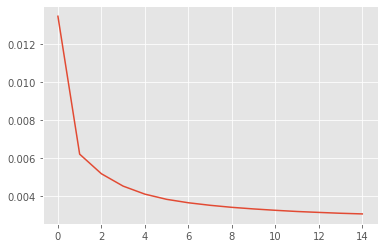

In [21]:
plt.style.use("ggplot")
plt.plot(losses)

In [22]:
data_iter = iter(train_loader)
imgs , _ = data_iter.next()

In [23]:
img = imgs[0]

In [24]:
img_permute = img.permute(1,2,0)

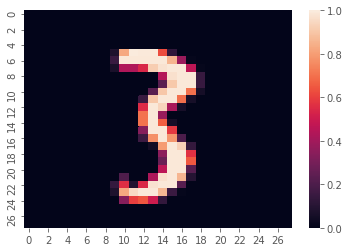

In [25]:
sns.heatmap(img_permute[: , : , 0])

In [26]:
#エンコードを行ってみる。
#モデルはGPU上にあるので、画像データもGPU上におく
x_en = model.en(imgs.to(device))

In [27]:
x_en2 = x_en[0].permute(1,2,0)

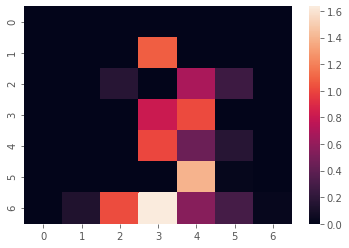

In [29]:
#エンコードした場合全部で16チャネルある。
#そのため今回16チャネルのうち一番最初のチャネルを可視化してみる。
#順伝番で計算しているのでdetachする
#ヒートマップに渡すときは二次元にして渡す必要がある。
sns.heatmap(x_en2[: , : , 0].detach().to("cpu"))
#ちょっと３には見えなくもない(笑)

In [30]:
#エンコードしてデコードしたものを書きだす。
x_ae = model(imgs.to(device))


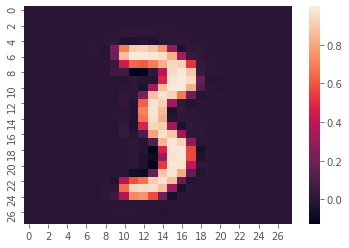

In [33]:
#ヒートマップに渡すときは二次元にして渡す必要がある。
sns.heatmap(x_ae[0].permute(1,2,0).detach().to("cpu")[:,:,0])